In [2]:
import numpy as np
import h5py
import pandas as pd
import os
import glob
import importlib
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
import utils.Vis
importlib.reload(utils.Vis)
from utils.Vis import plot_maps

/home/ali/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [52]:
# Config parameters
root = "/home/ali/graham-akhanf/EpLink/Eplink"
results_path = os.path.join(root,"ISC-pipeline","results","{dataset}","looISC","control")
atlases_path = os.path.join('.','ISC-pipeline','resources','atlases_fsLR_32K')

atlases = ['none', 'Glasser_2016', 'Desikan', 'Schaefer2018_17Networks_400', 'Yan2023_17Networks_400']
atlases_aliases = ['Vertex', 'Glasser 2016', 'Desikan', 'Schaefer 2018', 'Yan 2023']

datasets = ["eplink-p2", "eplink-p3"]
task_dataset = {'eplink-p2': 'hitchcock', 'eplink-p3': 'movie'}
source_dataset = {'eplink-p2': 'resampled2fsLR/32k_space_surfaces-parcellated',\
                  'eplink-p3': 'temporalResampled-parcellated'}
resampled_dataset = {'eplink-p2': 'N', 'eplink-p3': 'Y'}
ndummies_dataset = {'eplink-p2': 5, 'eplink-p3': 0}

fwhm = 0
confounds_idx = 1
target_volumes = 240

output_path = os.path.join(root, 'results', 'phases_combined', 'looISC')
os.makedirs(output_path, exist_ok=True)
# file_pattern = "looISC_task-{task}_hemi-{{hemi}}_fwhm-{fwhm}_confounds-{confounds_idx}_resampled-{resampled}_atlas-{atlas}.h5"

# Participants to exclude
subjid_exclude = [1,2,3,10]
subjid_exclude = ['{:04d}'.format(s) for s in subjid_exclude]

In [3]:
# Helper functions
def get_dimensions(filepath):
    """Extract dimensions of data from h5 data."""
    # Check file extension
    ext = os.path.splitext(filepath)[-1]
    
    # h5 file
    if ext == '.h5': 
        # Open the HDF5 file
        with h5py.File(filepath, 'r') as f:
            # Load the parcellated data
            data = f['parcellated_data'][:]
            # Return data dimensions
            n_rois, n_vol = data.shape
    
    # gii file
    elif ext == '.gii':
        # Load the GIFTI file by nibabel
        gii = nib.load(filepath)
        # Return data dimensions
        n_rois = gii.darrays[0].data.shape[0]
        n_vol = len(gii.darrays)
    
    return n_rois, n_vol

def load_HDF(filepath, n_vols, n_dummies=0):
    """Load data stored in the HDF files given the runs dataframe."""
    with h5py.File(filepath, 'r') as f:
            # Load the parcellated data
            data = f['parcellated_data'][:]
            data = data[:,n_dummies:n_dummies+n_vols] # Ignoring excessive volumes
    # Returns data with shape ROI x Time
    return data

def load_gii(filepath, n_vols, n_dummies=0):
    func_gii = nib.load(filepath)
    data = np.vstack([darray.data for darray in func_gii.darrays[n_dummies:n_dummies+n_vols]]).T
    # Returns data with shape Vertex x Time
    return data

def load_runs(runs_df, n_vols):
    # Loading only the last run
    fp = runs_df['full_path'].iloc[-1]
    # Checking file extension
    ext = os.path.splitext(fp)[-1]
    # Number of dummy scans
    n_dummies = runs_df['n_dummies'].iloc[-1]
    # h5 file
    if ext == '.h5':
        data = load_HDF(fp, n_vols, n_dummies)
    # gii file
    elif ext == '.gii':
        data = load_gii(fp, n_vols, n_dummies)
    
    return data

def get_info(filepath):
    """Extract subject, hemi, task, run, fwhm, confounds,
      rois, and number of volumes from a given file."""
    # Get file name
    basename = os.path.basename(filepath)
    # Split file name by '_'
    parts = basename.split('_')
    # Info dictionary
    info = {}
    info['full_path'] = filepath
    # Parse file name
    for part in parts:
        if part.startswith('sub-'):
            info['subject'] = part.split('sub-')[1]
        elif part.startswith('hemi-'):
            info['hemi'] = part.split('hemi-')[1]
        elif part.startswith('task-'):
            info['task'] = part.split('task-')[1]
        elif part.startswith('run-'):
            info['run'] = part.split('run-')[1]
        elif part.startswith('fwhm-'):
            info['fwhm'] = part.split('fwhm-')[1]
        elif part.startswith('confounds-'):
            info['confounds'] = part.split('confounds-')[1].split('_')[0]  # Assuming confounds is the last part before the file extension

    # Get dimensions for stored data    
    info['n_roi'], info['n_vol'] = get_dimensions(filepath)
    
    return info

def build_dataframe(directory, pattern=None, n_dummies=0):
    """Build a dataframe from files in the directory and its subdirectories."""
    # Default Pattern for search
    if pattern == None:
        subject, hemi, task, run, fwhm, confounds = ('*', '*', '*', '*', 0, 1)
        pattern = f"sub-{subject}_hemi-{hemi}_task-{task}_run-{run}_space-fsLR_den-32k_desc-denoised_fwhm-{fwhm}_confounds-{confounds}_atlas-glasser.h5"
    
    pattern = os.path.join(directory, 'sub-*', 'func', pattern)
    # Get all files matching the pattern
    files = glob.glob(pattern, recursive=True)
    # Building the dataframe
    df = pd.DataFrame([get_info(file) for file in files])
    df['n_dummies'] = n_dummies
    
    return df

In [53]:
for i in range(1,len(atlases)):
    print(atlases[i])
    df_comb = pd.DataFrame()
    for dataset in datasets:
        print(dataset)
        data_path = os.path.join(root, 'ISC-pipeline', 'results', f'{dataset}', f'{source_dataset[dataset]}', f'{atlases[i]}')

        subject, hemi, task, run, fwhm, confounds = ('*', '*', task_dataset[dataset], '*', 0, 1)
        datafile_pattern = f"sub-{subject}_task-{task}_run-{run}_hemi-{hemi}_confounds-{confounds}_bold.func.h5"

        df = build_dataframe(data_path, datafile_pattern, ndummies_dataset[dataset])
        # Exclude participants 
        df = df.drop(df[df['subject'].isin(subjid_exclude)].index)
        # Exclude files with less volumes
        df = df[df["n_vol"] >= target_volumes].reset_index(drop=True)

        df_comb = pd.concat((df_comb, df))

    # Sort files 
    df_comb = df_comb.sort_values(by=['subject', 'task', 'run'], ascending=[True]*3).reset_index()
    # Ignore some columns
    #['subject', 'task', 'run', 'hemi', 'fwhm', 'confounds', 'n_vol', 'full_path']
    df_comb = df_comb[['subject', 'task', 'run', 'hemi', 'n_vol', 'n_dummies', 'full_path']]

    # Get unique subjects
    subjects = df_comb['subject'].unique()
    controls = [s for s in subjects if int(s) > 5000]
    patients = [s for s in subjects if int(s) < 5000]
    n_subject = len(subjects)

    # Load data for control participants
    data_c = []
    for subj in controls:
        # Filter subject files 
        df_s = df_comb[df_comb['subject'] == subj]
        df_s_L = df_s[df_s['hemi'] == 'L']
        df_s_R = df_s[df_s['hemi'] == 'R']
        # Load runs
        d_L = load_runs(df_s_L, target_volumes)
        d_R = load_runs(df_s_R, target_volumes)
        data_c.append(np.concatenate((d_L,d_R),axis=0))

    # Stacking subjects data (Subject, Unit, Time)
    data_c = np.stack(data_c)

    # Load data for patient participants
    data_p = []
    for subj in patients:
        # Filter subject files 
        df_s = df_comb[df_comb['subject'] == subj]
        df_s_L = df_s[df_s['hemi'] == 'L']
        df_s_R = df_s[df_s['hemi'] == 'R']
        # Load runs
        d_L = load_runs(df_s_L, target_volumes)
        d_R = load_runs(df_s_R, target_volumes)
        data_p.append(np.concatenate((d_L,d_R),axis=0))

    # Stacking subjects data (Subject, Unit, Time)
    data_p = np.stack(data_p)

    #### lOO ISC controls
    n_controls, n_unit, n_vols = data_c.shape
    output_name = f"looISC_hemi-{{hemi}}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlases[i]}.h5"
    output_fullpath = os.path.join(output_path, output_name)

    # Sum subjects data (Unit, Time)
    data_sum_c = data_c.sum(axis=0)

    # Output will be shaped as (Subject, Unit)
    loo_ISC_c = np.zeros((n_controls, n_unit))
    for s in range(n_controls):
        for j in range(n_unit):
            sum_ts = data_sum_c[j,:].reshape((1,-1))
            sub_ts = data_c[s,j,:].reshape((1,-1))
            c = np.corrcoef(sub_ts, sum_ts-sub_ts)
            loo_ISC_c[s,j] = c[0,1]

    loo_ISC_dict = {'L': loo_ISC_c[:,:int(n_unit/2)],
                    'R': loo_ISC_c[:,int(n_unit/2):]}
    # Save ISCs as HDF5 file
    for hemi in ['L', 'R']:
        with h5py.File(output_fullpath.format(hemi=hemi), 'w') as f:
            f.create_dataset('loo_ISC', data=loo_ISC_dict[f'{hemi}'])

    #### ISC patients - controls
    n_patients, n_unit, n_vols = data_p.shape
    output_name = f"looISC_hemi-{{hemi}}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlases[i]}_patients.h5"
    output_fullpath = os.path.join(output_path, output_name)
    # Output will be shaped as (Subject, Unit)
    loo_ISC_p = np.zeros((n_patients, n_unit))
    for s in range(n_patients):
        for j in range(n_unit):
            sum_ts = data_sum_c[j,:].reshape((1,-1))
            sub_ts = data_p[s,j,:].reshape((1,-1))
            c = np.corrcoef(sub_ts, sum_ts)
            loo_ISC_p[s,j] = c[0,1]

    loo_ISC_dict_p = {'L': loo_ISC_p[:,:int(n_unit/2)],
                    'R': loo_ISC_p[:,int(n_unit/2):]}
    # Save ISCs as HDF5 file
    for hemi in ['L', 'R']:
        with h5py.File(output_fullpath.format(hemi=hemi), 'w') as f:
            f.create_dataset('loo_ISC', data=loo_ISC_dict_p[f'{hemi}'])

Glasser_2016
eplink-p2
eplink-p3


KeyboardInterrupt: 

(5, 14)
[[0]
 [0]
 [0]
 [0]
 [0]]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 4]]
(5, 14) (5, 14)
[0 0 0 0 0]


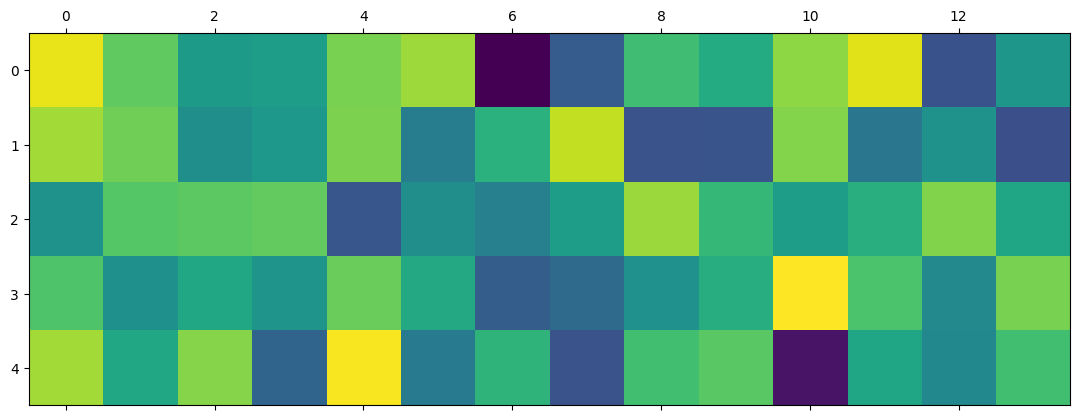

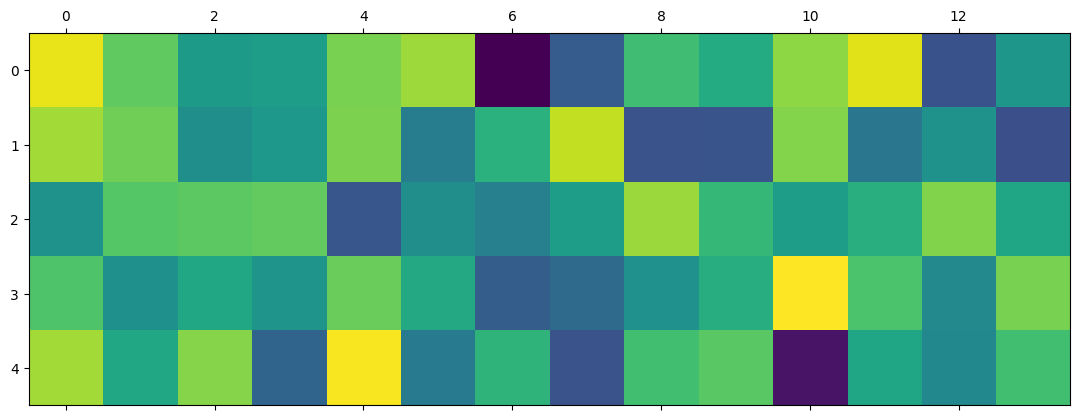

In [5]:
# Testing

import matplotlib.pyplot as plt
np.random.seed(2024)

n_perm = 20
n_controls = 5
n_vols = 14

data = np.random.normal(size=(n_controls,n_vols))
print(data.shape)

# generating the shift values and indices for a circular shift
shift_values = np.zeros((n_perm+1,n_controls),dtype=int)
for i in range(n_perm):
    shift_values[i+1,:] = np.random.randint(0, n_vols, size=n_controls)


for i in range(1):
    print(shift_values[i, :, np.newaxis])
    ind_c = (np.tile(np.arange(n_vols),(n_controls,1)) - shift_values[i, :, np.newaxis])
    ind_r = np.tile(np.arange(n_controls).reshape((-1,1)),(1,n_vols))
    print(np.tile(np.arange(n_vols),(n_controls,1)))
    print(ind_c)
    print(ind_r)
    print(ind_c.shape, ind_r.shape)
    print(shift_values[i, :])
    data_shifted = data[ind_r,ind_c]

plt.matshow(data)
plt.matshow(data_shifted)

In [4]:
def _perm_unit(data, shift_values):
    n_sub, n_vols = data.shape
    n_perm, n_sub = shift_values.shape
    # Shift the data accordingly
    ISC_u = np.zeros((n_perm, n_sub))
    for p in range(n_perm):
        ind_time = (np.tile(np.arange(n_vols),(n_sub,1)) - shift_values[p, :, np.newaxis])
        ind_subj = np.tile(np.arange(n_sub).reshape((-1,1)),(1,n_vols))
        data_shifted = data[ind_subj,ind_time]

        # Sum subjects data (Time)
        sum_ts = data_shifted.sum(axis=0)

        # Output will be shaped as (Subject, Unit)

        for s in range(n_sub):
            sub_ts = data_shifted[s,:].reshape((1,-1))
            c = np.corrcoef(sub_ts, sum_ts-sub_ts)
            ISC_u[p,s] = c[0,1]
    
    return ISC_u

In [5]:
circ_ratio = 0.1

output_path = os.path.join('.', 'results', 'phases_combined', 'looISC')
os.makedirs(output_path, exist_ok=True)

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

np.random.seed(2024)
n_perm = 10000

for a in range(1,len(atlases)):
    print(atlases[a])
    df_comb = pd.DataFrame()
    for dataset in datasets:
        print(dataset)
        data_path = os.path.join(root, 'ISC-pipeline', 'results', f'{dataset}', f'{source_dataset[dataset]}', f'{atlases[a]}')

        subject, hemi, task, run, fwhm, confounds = ('*', '*', task_dataset[dataset], '*', 0, 1)
        datafile_pattern = f"sub-{subject}_task-{task}_run-{run}_hemi-{hemi}_confounds-{confounds}_bold.func.h5"

        df = build_dataframe(data_path, datafile_pattern, ndummies_dataset[dataset])
        # Exclude files with less volumes
        df = df[df["n_vol"] >= target_volumes].reset_index(drop=True)

        df_comb = pd.concat((df_comb, df))

    # Sort files 
    df_comb = df_comb.sort_values(by=['subject', 'task', 'run'], ascending=[True]*3).reset_index()
    # Focus on some columns
    #['subject', 'task', 'run', 'hemi', 'fwhm', 'confounds', 'n_vol', 'full_path']
    df_comb = df_comb[['subject', 'task', 'run', 'hemi', 'n_vol', 'n_dummies', 'full_path']]

    # Get unique subjects
    subjects = df_comb['subject'].unique()
    controls = [s for s in subjects if int(s) > 5000]
    patients = [s for s in subjects if int(s) < 5000]
    n_subject = len(subjects)

    # Load data for control participants
    data_c = []
    for subj in controls:
        # Filter subject files 
        df_s = df_comb[df_comb['subject'] == subj]
        df_s_L = df_s[df_s['hemi'] == 'L']
        df_s_R = df_s[df_s['hemi'] == 'R']
        # Load runs
        d_L = load_runs(df_s_L, target_volumes)
        d_R = load_runs(df_s_R, target_volumes)
        data_c.append(np.concatenate((d_L,d_R),axis=0))

    # Stacking subjects data (Subject, Unit, Time)
    data_c = np.stack(data_c)
    n_controls, n_unit, n_vols = data_c.shape

    # Transpose data to have units in the first dimension (Unit, Subject, Time)
    data_c = data_c.transpose((1,0,2))

    # Generating the shift values for a circular shifts (Permutation, Subject)
    shift_values = np.zeros((n_perm+1,n_controls),dtype=int)
    for i in range(n_perm):
        shift_values[i+1,:] = np.random.randint(0, n_vols*circ_ratio, size=n_controls)

    # Permutations
    ISC_perm = np.zeros((n_perm+1,n_controls,n_unit))
    partial_perm = partial(_perm_unit, shift_values=shift_values)
    units = range(n_unit)

    # with ThreadPoolExecutor(max_workers=20) as executor:
    #     # Map the function to the items and keep track of the futures
    #     futures = {executor.submit(partial_perm, data=data_c[u,:,:].copy()): u for u in units}

    #     # Progress bar setup
    #     with tqdm(total=len(units)) as progress_bar:
    #         for future in as_completed(futures):
    #             # Result of a completed task
    #             u_ind = futures[future]  # Get the unit identifier
    #             ISC_perm[:,:,u_ind] = future.result()
    #             # Update the progress bar
    #             progress_bar.update(1)
    for u in tqdm(units):
        ISC_perm[:,:,u] = _perm_unit(data=data_c[u,:,:], shift_values=shift_values)

    output_name = f"permutations_looISC_hemi-{{hemi}}_fwhm-{fwhm}_confounds-{confounds_idx}_atlas-{atlases[a]}.h5"
    output_fullpath = os.path.join(output_path, output_name)

    ISC_perm_dict = {'L': ISC_perm[:,:,:int(n_unit/2)],
                    'R': ISC_perm[:,:,int(n_unit/2):]}
    # Save ISCs as HDF5 file
    for hemi in ['L', 'R']:
        with h5py.File(output_fullpath.format(hemi=hemi), 'w') as f:
            f.create_dataset('permutations_loo_ISC', data=ISC_perm_dict[f'{hemi}'])
            f.create_dataset('shift_values', data=shift_values)


Glasser_2016
eplink-p2
eplink-p3


 33%|███▎      | 120/362 [17:08<34:47,  8.62s/it]/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 362/362 [52:13<00:00,  8.65s/it]


Desikan
eplink-p2
eplink-p3


100%|██████████| 70/70 [10:01<00:00,  8.60s/it]


Schaefer2018_17Networks_400
eplink-p2
eplink-p3


 20%|██        | 81/402 [11:38<45:56,  8.59s/it]/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 402/402 [56:08<00:00,  8.38s/it]


Yan2023_17Networks_400
eplink-p2
eplink-p3


 15%|█▍        | 59/402 [08:06<46:57,  8.21s/it]/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 402/402 [55:18<00:00,  8.25s/it]
